# Practice 01

## Download dataset and create data structures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sps

In [2]:
!pip install kaggle

In [3]:
!kaggle datasets download -d arashnic/book-recommendation-dataset

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0
book-recommendation-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip -o book-recommendation-dataset.zip

Archive:  book-recommendation-dataset.zip
  inflating: Books.csv               
  inflating: DeepRec.png             
  inflating: Ratings.csv             
  inflating: Users.csv               
  inflating: classicRec.png          
  inflating: recsys_taxonomy2.png    


In [5]:
books = pd.read_csv('Books.csv', sep=',')
books.head()

/var/folders/b8/rzcf55796dx0l9hv3jf_nxnr0000gn/T/ipykernel_91848/3945710838.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('Books.csv', sep=',')


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
users = pd.read_csv('Users.csv', sep=',')
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [7]:
ratings = pd.read_csv('Ratings.csv', sep=',')
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
ratings['user_index'], user_uniques = pd.factorize(ratings['User-ID'])
ratings['item_index'], item_uniques = pd.factorize(ratings['ISBN'])

# Build sparse CSR matrix directly
URM = sps.csr_matrix(
    (ratings['Book-Rating'], (ratings['user_index'], ratings['item_index']))
)

print("URM shape:", URM.shape)
print("Non-zero entries:", URM.nnz)

URM shape: (105283, 340556)
Non-zero entries: 1149780


In [9]:
print(ratings['Book-Rating'][:100])
print(ratings['user_index'][:20])

0     0
1     5
2     0
3     3
4     6
     ..
95    0
96    0
97    6
98    0
99    0
Name: Book-Rating, Length: 100, dtype: int64
0      0
1      1
2      2
3      3
4      3
5      4
6      5
7      6
8      7
9      8
10     9
11     9
12     9
13     9
14     9
15     9
16    10
17    10
18    10
19    10
Name: user_index, dtype: int64


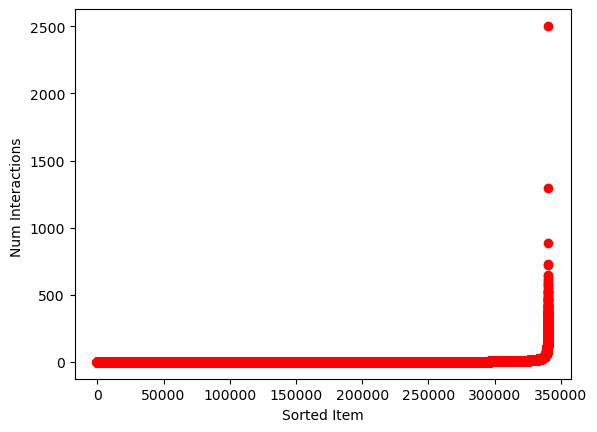

In [10]:
item_popularity = np.ediff1d(URM.tocsc().indptr)
item_popularity.sort()

plt.plot(item_popularity, 'ro')
plt.ylabel('Num Interactions ')
plt.xlabel('Sorted Item')
plt.show()

In [11]:
n_items = URM.shape[1]
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 3.38
Average per-item interactions for the top 10% popular items 19.08
Average per-item interactions for the least 10% popular items 1.00
Average per-item interactions for the median 10% popular items 1.00


In [12]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


In [13]:
# This is the right method

# %%timeit

for user_id in range(URM.shape[0]): 
    # Do something
    user_seen_items = URM.indices[URM.indptr[user_id]:URM.indptr[user_id+1]]

In [14]:
# This is the wrong method

# %%timeit

for user_id in range(URM.shape[0]):
    # Do something
    user_seen_items = URM[user_id].indices

In [15]:
train_test_split_percentage = 0.8

n_interactions = URM.nnz

URM.todense()[0:2, :]

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split_percentage, 1-train_test_split_percentage])


In [16]:
URM_coo = URM.tocoo()

train_URM = sps.csr_matrix((URM_coo.data[train_mask],
                            (URM_coo.row[train_mask], URM_coo.col[train_mask])))
test_URM = sps.csr_matrix((URM_coo.data[~train_mask],
                           (URM_coo.row[~train_mask], URM_coo.col[~train_mask])))
print("Train URM: {} shape and {} interactions".format(train_URM.shape, train_URM.nnz))
print("Test URM: {} shape and {} interactions".format(test_URM.shape, test_URM.nnz))    


Train URM: (105283, 340556) shape and 919975 interactions
Test URM: (105279, 340552) shape and 229805 interactions


## Define evaluation metrics

In [17]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

In [18]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

In [19]:
def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

In [20]:
# We pass as paramether the recommender class

def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 

## 0. Random Recommender

In [21]:
class RandomRecommender(object):
    def fit(self, train_URM):
        self.n_items = train_URM.shape[1]
        # fixed RNG for reproducible recommendations
        self.random_state = np.random.RandomState(0)
        
    def recommend(self, user_id, at):
        return self.random_state.choice(self.n_items, at, replace=False)


In [22]:
randRec = RandomRecommender()
randRec.fit(train_URM)
for user_id in range(5):
    recommended_items = randRec.recommend(user_id, at=5)
    print("User {}: recommended items {}".format(user_id, recommended_items))

User 0: recommended items [ 33114 259948 246161 216245 100823]
User 1: recommended items [94169 75495 46286 69366 23946]
User 2: recommended items [238102  94055  83538 337443  99988]
User 3: recommended items [250676  47826 144913 253999 148973]
User 4: recommended items [293572 254488 153547 314339 288952]


In [26]:
evaluate_algorithm(test_URM, randRec, at=5)

Recommender results are: Precision = 0.0000, Recall = 0.0000, MAP = 0.0000


## 1. Top Popular Recommender

In [27]:
class TopPopularRecommender(object):
    def fit(self, train_URM):
        self.train_URM = train_URM
        item_popularity = np.ediff1d(train_URM.tocsc().indptr)
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis=0)
    def recommend(self, user_id, at, remove_seen=True):
        if remove_seen:
            seen_items = self.train_URM.indices[self.train_URM.indptr[user_id]:self.train_URM.indptr[user_id + 1]]
            unseen_items_mask = np.in1d(self.popular_items, seen_items, assume_unique=True, invert=True)
            unseen_items = self.popular_items[unseen_items_mask]
            recommended_items = unseen_items[0:at]
        else:
            recommended_items = self.popular_items[:at]
        return recommended_items

In [28]:
topPopRec = TopPopularRecommender()
topPopRec.fit(train_URM)
for user_id in range(5):
    recommended_items = topPopRec.recommend(user_id, at=5)
    print("User {}: recommended items {}".format(user_id, recommended_items))
evaluate_algorithm(test_URM, topPopRec, at=5)


User 0: recommended items [ 452  421  424 2836 1365]
User 1: recommended items [ 452  421  424 2836 1365]
User 2: recommended items [ 452  421  424 2836 1365]
User 3: recommended items [ 452  421  424 2836 1365]
User 4: recommended items [ 452  421  424 2836 1365]
Recommender results are: Precision = 0.0064, Recall = 0.0107, MAP = 0.0089


## 2. Global Effect Recommender

In [29]:
globalAverage = np.mean(train_URM.data)

print("Global average rating is {:.4f}".format(globalAverage))

Global average rating is 2.8681


In [30]:
train_URM_unbiased = train_URM.copy() 
train_URM_unbiased.data = train_URM_unbiased.data - globalAverage

print(train_URM.data[:10])
print(train_URM_unbiased.data[:10])


[ 0  5  0  3  6  8  7 10  0  0]
[-2.86812142  2.13187858 -2.86812142  0.13187858  3.13187858  5.13187858
  4.13187858  7.13187858 -2.86812142 -2.86812142]


In [31]:
lambda_item = 25
lambda_user = 10

col_nnz = np.ediff1d(sps.csc_matrix(train_URM_unbiased).indptr)

item_mean_rating = train_URM_unbiased.sum(axis=0) / (col_nnz+lambda_item)
print(item_mean_rating.shape)
item_mean_rating = np.array(item_mean_rating).ravel()
print(item_mean_rating.shape)
item_mean_rating[col_nnz == 0] = -np.inf


(1, 340556)
(340556,)


In [32]:
print(item_mean_rating[:10])

[-0.1500237  -0.02726825  1.01841061  0.00507225  0.12045687  0.19495397
  0.32853498        -inf  0.45589593  0.15791693]


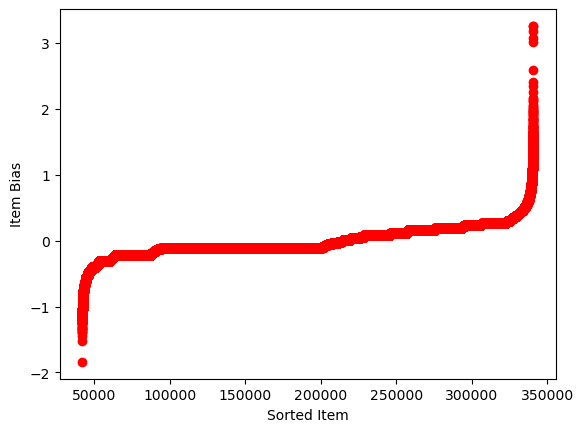

In [33]:
item_mean_rating = np.array(item_mean_rating).squeeze()
item_mean_rating = np.sort(item_mean_rating[item_mean_rating != 0])

plt.plot(item_mean_rating, 'ro')
plt.ylabel('Item Bias')
plt.xlabel('Sorted Item')
plt.show()

In [34]:
row_nnz = np.ediff1d(sps.csr_matrix(train_URM_unbiased).indptr)

user_mean_rating = train_URM_unbiased.sum(axis=1).ravel() / (row_nnz + lambda_user)

user_mean_rating = np.array(user_mean_rating).ravel()

user_mean_rating[row_nnz == 0 ] = -np.inf

print(user_mean_rating[:10])


[-0.26073831  0.19380714 -0.26073831  0.27197976        -inf  0.46653442
        -inf  0.37562533  0.6483526  -0.81946326]


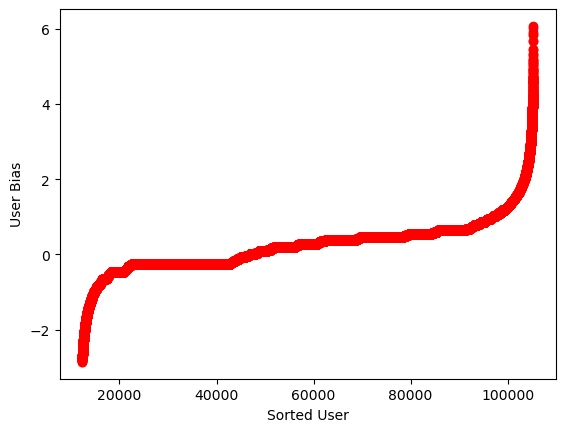

In [35]:
user_mean_rating = np.array(user_mean_rating).squeeze()
user_mean_rating = np.sort(user_mean_rating[user_mean_rating!=0.0])

plt.plot(user_mean_rating, 'ro')
plt.ylabel('User Bias')
plt.xlabel('Sorted User')
plt.show()

In [41]:
class GlobalEffectRecommender(object):
    def fit(self, train_URM, lambda_user = 10, lambda_item=25):
        self.train_URM = train_URM
        self.mu = self.train_URM.data.sum() / self.train_URM.nnz
        self.bestRatedItems = np.flip(np.argsort(item_mean_rating), axis=0)
        
    def recommend(self, user_id, at, remove_seen=True):
        if remove_seen:
            seen_items = self.train_URM.indices[self.train_URM.indptr[user_id]:self.train_URM.indptr[user_id + 1]]
            unseen_items_mask = np.in1d(self.bestRatedItems, seen_items, assume_unique=True, invert=True)
            unseen_items = self.bestRatedItems[unseen_items_mask]
            recommended_items = unseen_items[0:at]
        else:
            recommended_items = self.bestRatedItems[:at]
        return recommended_items
    

In [42]:
globalEffectRecommender = GlobalEffectRecommender()
globalEffectRecommender.fit(train_URM)

evaluate_algorithm(test_URM, globalEffectRecommender)

Recommender results are: Precision = 0.0000, Recall = 0.0000, MAP = 0.0000


In [43]:
for rating_threshold in range(0, 5):
    
    print("Removing ratings <= {}".format(rating_threshold))
    
    URM_train_filtered = train_URM.copy()
    URM_train_filtered.data[train_URM.data <= rating_threshold] = 0
    
    URM_train_filtered.eliminate_zeros()
    
    topPopRecommender = TopPopularRecommender()
    topPopRecommender.fit(URM_train_filtered)
    
    evaluate_algorithm(train_URM, topPopRecommender)

Removing ratings <= 0
Recommender results are: Precision = 0.0064, Recall = 0.0063, MAP = 0.0058
Removing ratings <= 1
Recommender results are: Precision = 0.0066, Recall = 0.0065, MAP = 0.0059
Removing ratings <= 2
Recommender results are: Precision = 0.0067, Recall = 0.0068, MAP = 0.0051
Removing ratings <= 3
Recommender results are: Precision = 0.0069, Recall = 0.0070, MAP = 0.0046
Removing ratings <= 4
Recommender results are: Precision = 0.0036, Recall = 0.0021, MAP = 0.0029
